# Ideas for presentation
1. Impossibility results: Why do we need multi-probabilistic predictions?
2. Full Venn-ABERS implementation. Requires quite a bit of coding... I am not sure I want to implement the PAVA algorithm on my own...
3. Full Venn-prediction implementation? Not necessarily Venn-ABERS, but some other predictor could be nice. E.g. nearest neighbours and such.
3. Venn decision making? Can we use the multi-probabilities to maximise e.g. expected utility?
4. Perhaps not for presentation, but can we improve on the PAVA algorithm? This is a nice optimisation problem to tackle with Yishao, perhaps?

If I have a utility function $U:Y\times D \to \mathbb{R}$, where $D$ is some decision space, I can compute the utility of any decision $d$.If I also have probabilities for each label $y$, I can compute the conditional expected utility, given a test object $x$!

In [2]:
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from venn_abers import VennAbersCalibrator
from copy import deepcopy
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt

# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X_raw = mushroom.data.features 
y_raw = mushroom.data.targets 

X = np.array([LabelEncoder().fit(col).transform(col) for col in X_raw.values.T]).T
y = y_raw.values.reshape(1, -1)[0]
y = (y=='p').astype('int')

df = deepcopy(X_raw)
df['poisonous'] = y

In [3]:
# Function to sample balanced training and test sets
def sample_balanced_datasets_and_encode(df, target_column, train_size, test_size, random_state=None):
    # Ensure train_size and test_size are even
    if train_size % 2 != 0 or test_size % 2 != 0:
        raise ValueError("train_size and test_size must be even numbers to balance classes.")
    
    # Check that both classes have enough samples
    class_counts = df[target_column].value_counts()
    if any(class_counts < (train_size + test_size) // 2):
        raise ValueError("Not enough samples in one of the classes to create the requested balanced sets.")
    
    # Split the DataFrame by class
    class_0 = df[df[target_column] == 0]
    class_1 = df[df[target_column] == 1]
    
    # Sample train_size / 2 and test_size / 2 from each class
    train_sample_0 = class_0.sample(n=train_size // 2, random_state=random_state)
    train_sample_1 = class_1.sample(n=train_size // 2, random_state=random_state)
    test_sample_0 = class_0.drop(train_sample_0.index).sample(n=test_size // 2, random_state=random_state)
    test_sample_1 = class_1.drop(train_sample_1.index).sample(n=test_size // 2, random_state=random_state)
    
    # Combine and shuffle the samples
    balanced_train = pd.concat([train_sample_0, train_sample_1]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    balanced_test = pd.concat([test_sample_0, test_sample_1]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Split into features and target
    X_train = balanced_train.drop(columns=[target_column])
    Y_train = balanced_train[target_column]
    X_test = balanced_test.drop(columns=[target_column])
    Y_test = balanced_test[target_column]

    # Encode the features
    X_train = np.array([LabelEncoder().fit(col).transform(col) for col in X_train.values.T]).T
    X_test = np.array([LabelEncoder().fit(col).transform(col) for col in X_test.values.T]).T
    Y_train = Y_train.values.reshape(1, -1)[0]
    Y_test = Y_test.values.reshape(1, -1)[0]

    return X_train, Y_train, X_test, Y_test

def U(y, d):
    if y == 0:
        if d == 'eat':
            util = 1
        if d == 'not eat':
            util = 0
    if y == 1:
        if d == 'eat':
            util = -10
        if d == 'not eat':
            util = 1
    return util

def make_decision_based_on_prediction(yhat):
    d_arr = np.empty_like(yhat)
    for i, y in enumerate(yhat):
        d_arr[i] = 'eat' if y == 'e' else 'not eat'
    return d_arr

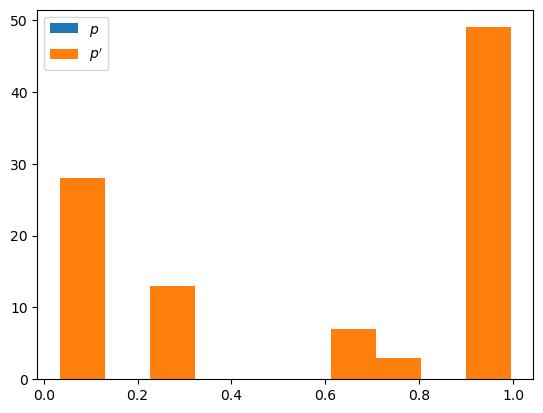

In [ ]:
r = 2024
test_size = 100
training_set_size = 1000

X_train, Y_train, X_test, Y_test = sample_balanced_datasets_and_encode(df, target_column='poisonous', train_size=training_set_size, test_size=test_size, random_state=r)

clf = KNeighborsClassifier(n_neighbors=5)

# Define Venn-ABERS calibrator
va = VennAbersCalibrator(estimator=clf, inductive=True, cal_size=0.5, random_state=101)

# Fit on the training set
va.fit(X_train, Y_train)

# Generate probabilities and class predictions on the test set
p_prime, P0_P1 = va.predict_proba(X_test, p0_p1_output=True)
P0_P1 = P0_P1[0]

plt.hist(P0_P1[:,1] / (1 - P0_P1[:,0] + P0_P1[:,1]), label=r'$p$')
plt.hist(p_prime[:,1], label=r"$p'$")
plt.legend()

In [25]:
P0_P1[:,1] / (1 - P0_P1[:,0] + P0_P1[:,1]) == p_prime[:,1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

# Very carefully, check

Multiprobability output: (0.0, 0.4)
True label: 0


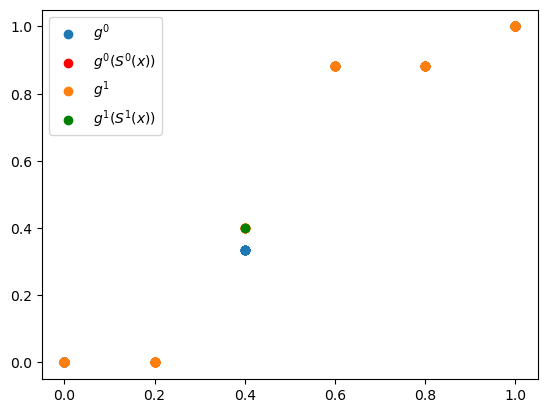

In [121]:
r = 2024
test_size = 100
training_set_size = 100

from sklearn.naive_bayes import GaussianNB


X_train, Y_train, X_test, Y_test = sample_balanced_datasets_and_encode(df, target_column='poisonous', train_size=training_set_size, test_size=test_size, random_state=r)

i = 9
x = X_test[0]

clf = KNeighborsClassifier(n_neighbors=5)

y_hyp = 0

X_fit = np.vstack((X_train, x))
y_fit = np.append(Y_train, y_hyp)
clf.fit(X_fit, y_fit)

scores = clf.predict_proba(X_fit)

IR = IsotonicRegression(y_min=0, y_max=1)
IR.fit(scores[:,1], y_fit)
cal_scores = IR.predict(scores[:,1])
plt.scatter(scores[:,1], cal_scores, label=r'$g^0$')
p0 = cal_scores[-1]
plt.scatter(scores[-1,1], p0, label=r'$g^0(S^0(x))$', color='red')

y_hyp = 1

X_fit = np.vstack((X_train, x))
y_fit = np.append(Y_train, y_hyp)
clf.fit(X_fit, y_fit)

scores = clf.predict_proba(X_fit)

IR = IsotonicRegression(y_min=0, y_max=1)
IR.fit(scores[:,1], y_fit)
cal_scores = IR.predict(scores[:,1])
plt.scatter(scores[:,1], cal_scores, label=r'$g^1$')
p1 = cal_scores[-1]
plt.scatter(scores[-1,1], p1, label=r'$g^1(S^1(x))$', color='green')

plt.legend()

print(f'Multiprobability output: ({p0}, {p1})')
print(f'True label: {Y_test[i]}')

array([0.28571429, 0.42857143])

# The below approach does not work! Do it again.

In [ ]:
r = 2024
neighbours = 5
test_size = 4
training_set_size = 10

X_train, Y_train, X_test, Y_test = sample_balanced_datasets_and_encode(df, target_column='poisonous', train_size=training_set_size, test_size=test_size, random_state=r)

ivap_rf = RandomForestClassifier(random_state=r)
ivap = VennAbersCalibrator(estimator=ivap_rf, inductive=True, cal_size=0.3, random_state=r)
ivap.fit(X_train, Y_train)
P = ivap.predict_proba(X_test)
print(f'Petej: {P[:,1]}')


clf = RandomForestClassifier(random_state=r)
clf.fit(X_train, Y_train)
P0_P1 = np.empty(shape=(X_test.shape[0],2))
for i, x in enumerate(X_test):
    
    for j, y_hyp in enumerate(clf.classes_):
        clf = RandomForestClassifier(random_state=r)
        clf.fit(np.vstack((X_train, x)), np.append(Y_train, y_hyp))
        P = clf.predict_proba(np.vstack((X_train, x)))
        IR = IsotonicRegression(y_min=0, y_max=1)

        IR.fit(P[:,1], (np.append(Y_train, y_hyp)=='p').astype('float'))
        py = IR.predict(np.atleast_1d(clf.predict_proba(x.reshape(1,-1))[0,1]))
        P0_P1[i, j] = py

P0_P1[:,1] / (1 - P0_P1[:,0] + P0_P1[:,1])
P0_P1

Petej: [0.33333333 0.75       0.33333333 0.5       ]


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

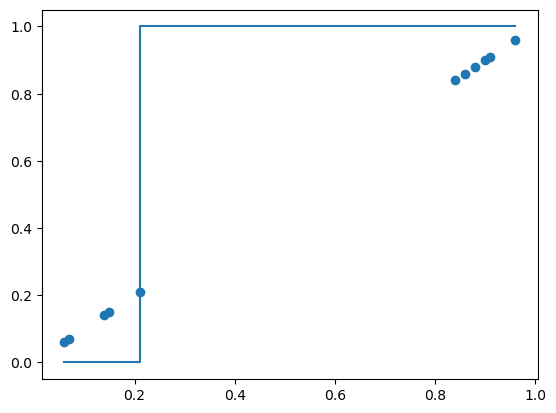

In [ ]:
sorted_scores = sorted(clf.predict_proba(np.vstack((X_train, x)))[:,1])
sorted_cal = IR.predict(sorted_scores)
plt.step(sorted_scores, sorted_cal)
plt.scatter(sorted_scores, sorted_scores)

In [8]:
Y_test

array(['e', 'p', 'p', 'e'], dtype=object)

# Try to mimic exactly their experiment

In [ ]:
neighbours = 5
test_size = 10#00
runs = 10
result = {}
for training_set_size in tqdm(range(20, 62, 2)):

    res = np.zeros(shape=(runs, 4))
    for r in range(runs):
        X_train, Y_train, X_test, Y_test = sample_balanced_datasets_and_encode(df, target_column='poisonous', train_size=training_set_size, test_size=test_size, random_state=r)
        knn = KNeighborsClassifier(n_neighbors=neighbours, metric='hamming')
        knn.fit(X_train, Y_train)

        ivap_knn = KNeighborsClassifier(n_neighbors=neighbours, metric='hamming')
        ivap = VennAbersCalibrator(estimator=ivap_knn, inductive=True, cal_size=0.3, random_state=r)
        ivap.fit(X_train, Y_train)

        # Base: utility of predictions
        yhat = knn.predict(X_test)
        decisions = make_decision_based_on_prediction(yhat)
        Utility = 0
        for d, y_true in zip(decisions, Y_test):
            Utility += U(y_true, d)

        U_base = Utility

        # Base proba: Use predict_proba to maximise expectation
        Utility = 0
        P_proba = knn.predict_proba(X_test)
        for probs, y_true in zip(P_proba, Y_test):
            utility = {}
            for d in ['eat', 'not eat']:
                u = 0
                for p, y in zip(probs, knn.classes_):
                    u += p*U(y, d)
                utility[d] = u
            # Choose decision with highest expected utility
            d = max(utility, key=utility.get)
            Utility += U(y_true, d)

        U_base_prob = Utility

        # Venn-ABERS Minimax
        P0_P1 = np.empty(shape=(X_test.shape[0],2))
        for i, x in enumerate(X_test):
            
            for j, y_hyp in enumerate(knn.classes_):
                clf = KNeighborsClassifier(n_neighbors=neighbours, metric='hamming')
                clf.fit(np.vstack((X_train, x)), np.append(Y_train, y_hyp))
                P = clf.predict_proba(np.vstack((X_train, x)))
                IR = IsotonicRegression(y_min=0, y_max=1)

                IR.fit(P[:,1], (np.append(Y_train, y_hyp)=='p').astype('float'))
                py = IR.predict(np.atleast_1d(clf.predict_proba(x.reshape(1,-1))[0,1]))
                P0_P1[1, j] = py

        Utility = 0

        for probs, y_true in zip(P0_P1, Y_test):

            utility_mat = np.zeros((2,2))
            probs0 = [1-probs[0], probs[0]]
            probs1 = [1-probs[1], probs[1]]

            for i, d in enumerate(['eat', 'not eat']):
                u = 0
                for p, y in zip(probs0, knn.classes_):
                    u += p*U(y, d)
                utility_mat[0, i] = u

                u = 0
                for p, y in zip(probs1, knn.classes_):
                    u += p*U(y, d)
                utility_mat[1, i] = u

            regret = utility_mat.max() - utility_mat
            d = 'not eat' if np.argwhere(regret == regret.max(axis=0).min())[0,1] == 1 else 'eat'
            Utility += U(y_true, d)

        U_minimax = Utility

        # Venn-ABERS
        Utility = 0
        P = ivap.predict_proba(X_test)
        for probs, y_true in zip(P, Y_test):
            utility = {}
            for d in ['eat', 'not eat']:
                u = 0
                for p, y in zip(probs, ivap.classes):
                    u += p*U(y, d)
                utility[d] = u

            # Choose decision with highest expected utility
            d = max(utility, key=utility.get)
            Utility += U(y_true, d)
        
        U_va = Utility

        res[r, 0] = U_base
        res[r, 1] = U_base_prob
        res[r, 2] = U_minimax
        res[r, 3] = U_va

    result[training_set_size] = res.mean(axis=0)
    print(f'Size={training_set_size}: {res.mean(axis=0)/Y_test.shape[0]}')

  0%|          | 0/21 [00:00<?, ?it/s]

Size=20: [-0.12  0.47  0.11  0.5 ]
Size=22: [0.41 0.66 0.5  0.5 ]
Size=24: [0.54 0.65 0.5  0.5 ]
Size=26: [0.37 0.56 0.5  0.5 ]
Size=28: [0.05 0.75 0.5  0.5 ]
Size=30: [0.49 0.65 0.5  0.5 ]
Size=32: [0.56 0.64 0.5  0.5 ]
Size=34: [0.27 0.56 0.5  0.5 ]
Size=36: [0.16 0.67 0.5  0.5 ]
Size=38: [0.16 0.52 0.5  0.5 ]
Size=40: [0.15 0.41 0.5  0.5 ]
Size=42: [0.39 0.69 0.5  0.5 ]
Size=44: [0.08 0.59 0.5  0.5 ]
Size=46: [0.57 0.72 0.5  0.5 ]
Size=48: [0.19 0.52 0.5  0.5 ]
Size=50: [0.41 0.49 0.5  0.5 ]
Size=52: [0.57 0.64 0.5  0.5 ]
Size=54: [-0.27  0.47  0.5   0.52]
Size=56: [0.38 0.8  0.5  0.54]
Size=58: [-0.04  0.77  0.5   0.5 ]
Size=60: [0.45 0.61 0.5  0.5 ]


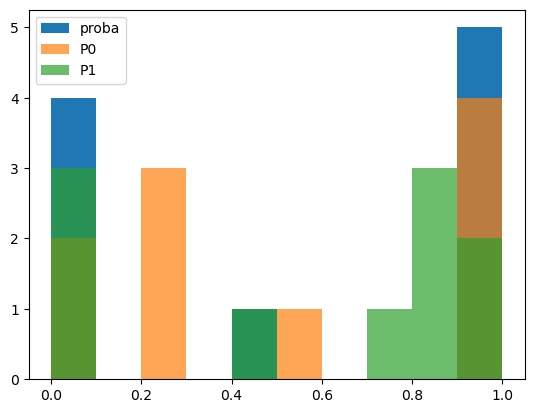

In [10]:
plt.hist(P_proba[:,1], label='proba')
plt.hist(P0_P1[:,1], alpha=0.7, label='P0')
plt.hist(P0_P1[:,0], alpha=0.7, label='P1')
plt.legend()

<Axes: >

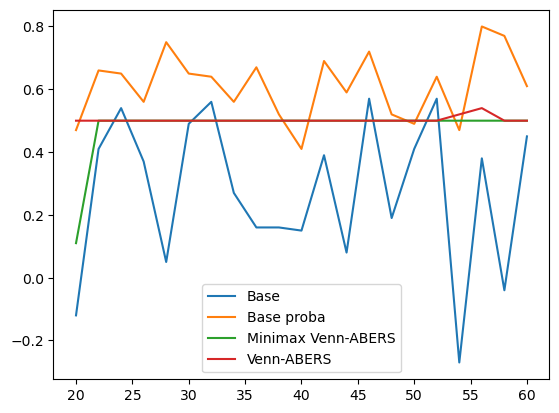

In [11]:
df_result = pd.DataFrame(result).T/test_size
df_result.columns = ['Base', 'Base proba', 'Minimax Venn-ABERS', 'Venn-ABERS']
df_result.plot()#[['Base proba', 'Minimax Venn-ABERS']].plot()

# Old stuff

In [23]:
runs = 1000

neighbours = 5

res = np.zeros(shape=(runs, 4))
for r in tqdm(range(runs)):

    training_set_size = 20
    test_set_size = 1000

    X_train, Y_train, X_test, Y_test = sample_balanced_datasets_and_encode(df, target_column='poisonous', train_size=training_set_size, test_size=test_size, random_state=r)
    knn = KNeighborsClassifier(n_neighbors=neighbours, metric='hamming')
    ivap = VennAbersCalibrator(estimator=knn, inductive=True, cal_size=0.3, random_state=r)
    ivap.fit(X_train, Y_train)
    P, P0_P1 = ivap.predict_proba(X_test, p0_p1_output=True)
    knn = KNeighborsClassifier(n_neighbors=neighbours, metric='hamming')
    knn.fit(X_train, Y_train)
    yhat = knn.predict(X_test)

    res[r, 0] = run_predictions()
    res[r, 1] = run_predict_proba()
    res[r, 2] = run_logloss_agg()
    res[r, 3] = run_minimax()


# print(f'Base: {run_predictions()}')
# print(f'Base proba: {run_predict_proba()}')
# print(f'Logloss opt: {run_logloss_agg()}')
# print(f'Minimax: {run_minimax()}')

res.mean(axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

array([-0.001504,  0.00513 ,  0.005   ,  0.005   ])

# All below thing should be done for a buch of different seeds!!

## First, use the (log loss optimal) aggregated probabilities

In [16]:
def run_logloss_agg():
    Utility = 0
    for probs, y_true in zip(P, Y_test):
        utility = {}
        for d in ['eat', 'not eat']:
            u = 0
            for p, y in zip(probs, ivap.classes):
                u += p*U(y, d)
            utility[d] = u

        # Choose decision with highest expected utility
        d = max(utility, key=utility.get)
        Utility += U(y_true, d)

    return Utility/test_set_size

## Just using the predicted labels

In [17]:
def run_predictions():
    decisions = make_decision_based_on_prediction(yhat)
    Utility = 0
    for d, y_true in zip(decisions, Y_test):
        # Choose decision with highest expected utility
        Utility += U(y_true, d)

    return Utility/test_set_size

## And using predict_proba

In [18]:
def run_predict_proba():
    Utility = 0
    P_proba = knn.predict_proba(X_test)
    for probs, y_true in zip(P_proba, Y_test):
        utility = {}
        for d in ['eat', 'not eat']:
            u = 0
            for p, y in zip(probs, knn.classes_):
                u += p*U(y, d)
            utility[d] = u

        # Choose decision with highest expected utility
        d = max(utility, key=utility.get)
        Utility += U(y_true, d)

    return Utility/test_set_size

# Pick out the correct choices (unrealistic but interesting)

In [19]:
Utility = 0

P_multi = P0_P1[0]

for probs, y_true in zip(P_multi, Y_test):
    if y_true == 'p':
        p1 = probs[1]
        p0 = 1 - p1
    else:
        p1 = probs[0]
        p0 = 1 - p1
    utility = {}
    for d in ['eat', 'not eat']:
        u = 0
        for p, y in zip([p0, p1], ivap.classes):
            u += p*U(y, d)
        utility[d] = u

    # Choose decision with highest expected utility
    d = max(utility, key=utility.get)
    Utility += U(y_true, d)

Utility/test_set_size

IndexError: invalid index to scalar variable.

It is clear that the utility maximisation seems to help a bit, especially for small training sets. However, the uncalibrated probabilities are better...

# Now, what about using the muliti-probabilities?
The loss function is $-U$. We aggregated to optimise log loss before. Could we get something similar for this one?
The above is not quite correct, as this loss is with regard to the prediciton $\hat{y}$, not the probability...

Alternatively, could we somehow get an upper and lower bound on expected utility, and use it somehow?
Perhaps coumpute upper and lower expectation, and taking decision that maximise their sum? Or require both to be positive? Otherwise reject?

In [20]:
def run_minimax():
    Utility = 0
    P_multi = P0_P1[0]

    for probs, y_true in zip(P_multi, Y_test):

        utility_mat = np.zeros((2,2))
        probs0 = [1-probs[0], probs[0]]
        probs1 = [1-probs[1], probs[1]]

        for i, d in enumerate(['eat', 'not eat']):
            u = 0
            for p, y in zip(probs0, ivap.classes):
                u += p*U(y, d)
            utility_mat[0, i] = u

            u = 0
            for p, y in zip(probs1, ivap.classes):
                u += p*U(y, d)
            utility_mat[1, i] = u

        regret = utility_mat.max() - utility_mat
        d = 'not eat' if np.argwhere(regret == regret.max(axis=0).min())[0,1] == 1 else 'eat'
        Utility += U(y_true, d)

    return Utility/test_set_size